In [ ]:
# Install the required libraries
#SAM
!pip3 install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip3 install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip3 install datasets
!pip3 install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip3 install patchify

In [3]:
!nvidia-smi

Wed Jul  3 09:47:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:17:00.0 Off |                    0 |
| N/A   34C    P0             55W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Get the data ready to train 

In [1]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# this function will be used to get an array of images from a folder

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array


## Sort, crop, and mask all the images

In [2]:
# this is based on if the image has a white pixel at 25, 100
# ussually this seperates the two image types

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

folder_path_val = './data/val_images'
folder_path_train = './data/training_images'
folder_path_no_tumor = './data/images_wo_tumor'

train_array = read_images_to_array(folder_path_train)
val_array = read_images_to_array(folder_path_val)
ntumor_array = read_images_to_array(folder_path_no_tumor)

# use the split function 

training_masks, training_raw = split_images(train_array) 
val_masks, val_raw = split_images(val_array) 


To test out if the function above works:

In [3]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


Text(0.5, 1.0, 'Raw Image (validation)')

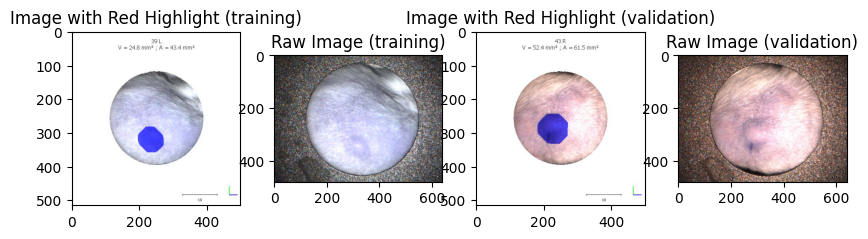

In [4]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [5]:
# this crops out the noise from the raw images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

training_raw = crop_raw_images(training_raw)
val_raw = crop_raw_images(val_raw) 
ntumor_array = crop_raw_images(ntumor_array)

In [6]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


Text(0.5, 1.0, 'Raw Image (validation)')

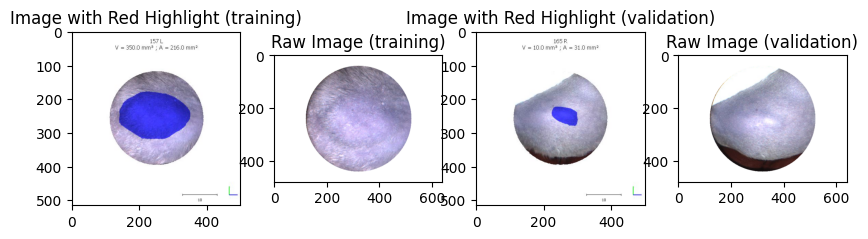

In [7]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [8]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


In [9]:
import numpy as np
import cv2

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

training_masks = crop_masks(training_masks)
val_masks = crop_masks(val_masks)


Text(0.5, 1.0, 'Raw Image (validation)')

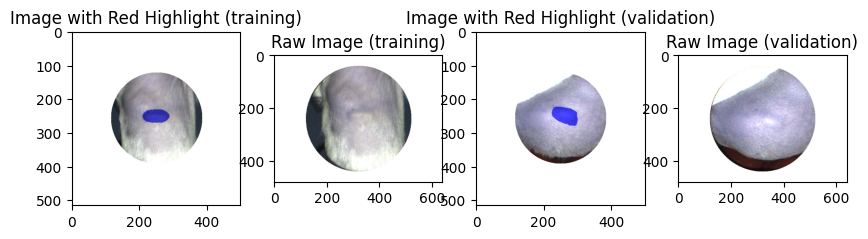

In [10]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [11]:
# function to turn the red region in the masks to binary masks 

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

training_masks = create_binary_masks(training_masks) 
val_masks = create_binary_masks(val_masks)

In [12]:
import numpy as np

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array) - 1): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks
        
ntumor_masks = create_blank_masks(ntumor_array)

In [13]:
ntumor_masks = np.array(ntumor_masks)

ntumor_masks.shape

(41, 256, 256)

Text(0.5, 1.0, 'Raw Image (validation)')

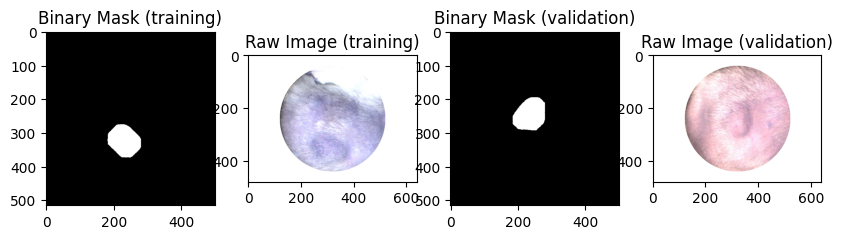

In [14]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [15]:
from PIL import Image
import numpy as np

def resize_binary_masks(image_array): 
    
    resized_binary_masks = []
    
    for image in image_array: 
        
        # crop 
        y=0
        x=0
        h=480
        w=640
        
        cropped_image = image[y:y+h, x:x+w]
        
        padding = 70 
        
        padded_img = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_binary_masks.append(padded_img) 
    
    return resized_binary_masks

training_masks = resize_binary_masks(training_masks) 
val_masks = resize_binary_masks(val_masks)

Text(0.5, 1.0, 'Raw Image (validation)')

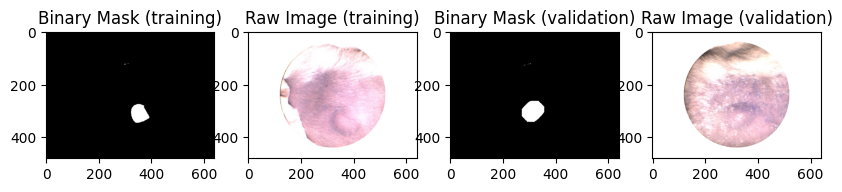

In [16]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [17]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Now we have to resize the images in order to use them for training effectivly:

In [18]:
# now that we see that all the data can fit within 256x256
# we can write code that will crop out the images 

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images 
                              
training_raw = crop_images(training_raw) 
training_masks = crop_images(training_masks) 

val_raw = crop_images(val_raw) 
val_masks = crop_images(val_masks)

ntumor_array = crop_images(ntumor_array)

Text(0.5, 1.0, 'Raw Image (validation)')

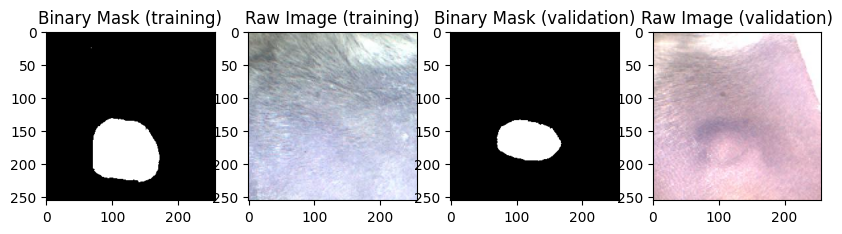

In [19]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

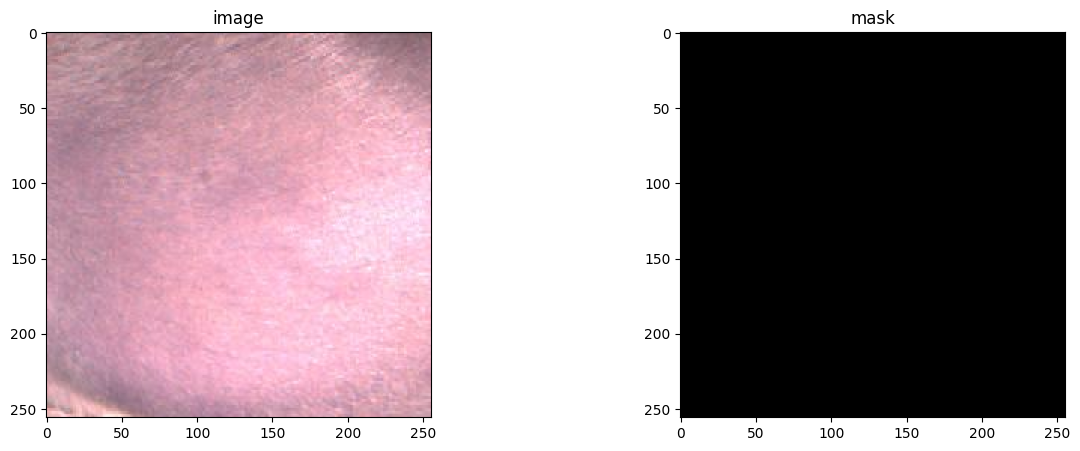

In [20]:
# test images wihtout a tumor

rand = random.randint(0, len(ntumor_array))

fig, ax = plt.subplots(1,2, figsize=(15, 5)) 

ax[0].imshow(ntumor_array[rand])
ax[0].set_title('image')

ax[1].imshow(ntumor_masks[rand], cmap="gray")
ax[1].set_title('mask')

plt.show()

In [21]:
import cv2
import random
import numpy as np

# Convert lists to numpy arrays before augmentation
training_raw = np.array(training_raw)
training_masks = np.array(training_masks)
val_raw = np.array(val_raw)
val_masks = np.array(val_masks)
ntumor_array = np.array(ntumor_array)
ntumor_masks = np.array(ntumor_masks)

def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
        for i in range(len(image_array_raw)):  # Remove the -1 here
            image_raw = image_array_raw[i]
            image_binary = image_array_binary[i]

            flipped_image_raw = cv2.flip(image_raw, 1)
            flipped_image_binary = cv2.flip(image_binary, 1)

            # Random angle
            angle = random.uniform(-30, 30)
            (h, w) = flipped_image_raw.shape[:2]
            center = (w // 2, h // 2)

            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
            augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

            aug_raw.append(augmented_image_raw)
            aug_masks.append(augmented_image_binary)

    # Extend original arrays with augmented data
    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

# Example usage:
training_raw, training_masks = augment_image_array(training_raw, training_masks, 50)
val_raw, val_masks = augment_image_array(val_raw, val_masks, 50)
ntumor_array, ntumor_masks = augment_image_array(ntumor_array, ntumor_masks, 20)


In [22]:
# test the size 

training_raw = np.concatenate((training_raw, ntumor_array), axis=0) 
training_masks = np.concatenate((training_masks, ntumor_masks), axis=0) 

print(len(ntumor_array)) 
print(len(training_raw))
print(len(val_raw))

861
8664
1836


Now to test if the augmentation function worked correctly 

Text(0.5, 1.0, 'Raw Image (validation)')

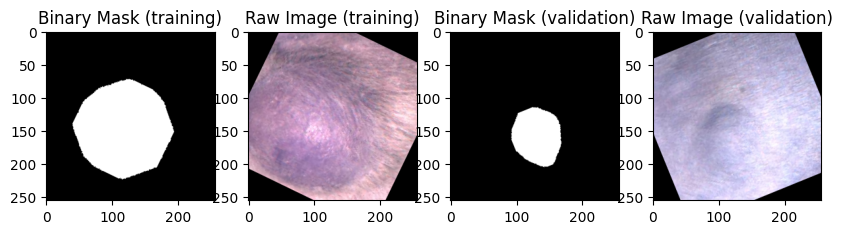

In [23]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [24]:
# convert to numpy array 
import numpy as np 

training_raw = np.array(training_raw) 
training_masks = np.array(training_masks) 

val_raw = np.array(val_raw)
val_masks = np.array(val_masks) 

# Create the dataset

In [25]:
# now create a dataset with these images

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in training_raw],
    "label": [Image.fromarray(mask) for mask in training_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_raw],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [26]:
print(len(val_dataset_dict["image"]))
print(len(val_dataset_dict["label"]))

print(len(training_dataset_dict["image"]))
print(len(training_dataset_dict["label"]))

1836
1836
8664
8664


In [ ]:
# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [ ]:
print("Training images shape:", training_raw.shape)
print("Training masks shape:", training_masks.shape)
print("Validation images shape:", val_raw.shape)
print("Validation masks shape:", val_masks.shape)

In [ ]:
# now to check that everything is working 

# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_dataset["label"][rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_dataset["image"][rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_dataset["label"][rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_dataset["image"][rand_val]) 
ax[3].set_title("Raw Image (validation)")

# Hide axis ticks and labels
for axe in ax:
    axe.set_xticks([])
    axe.set_yticks([])
    axe.set_xticklabels([])
    axe.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

# Train the Model

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
from torch.utils.data import random_split, DataLoader

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)


train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 


In [ ]:
example = training_dataset[0]
for k,v in example.items():
  print(k,v.shape)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

In [ ]:
batch["ground_truth_mask"].shape

In [ ]:
batch["pixel_values"].shape

In [ ]:
batch["input_boxes"].shape

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./models/mito_model_checkpoint3.pth")



# Test the model 

## Test with box prompt

In [25]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [26]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/mito_model_checkpoint3.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [28]:
# load testing data (note: this data is sampled from the training set)
testing_folder_path = './data/testing_images'
testing_images = read_images_to_array(testing_folder_path)

# split into two types 
testing_masks, testing_raw = split_images(testing_images)

# crop and mask images to get ready for testing 
testing_raw = crop_raw_images(testing_raw)
testing_masks = crop_masks(testing_masks) 

# create binary masks 
testing_masks = create_binary_masks(testing_masks)

#resize binary masks 
testing_masks = resize_binary_masks(testing_masks) 

# crop both sets of images to 256x256 
testing_masks = crop_images(testing_masks) 
testing_raw = crop_images(testing_raw)

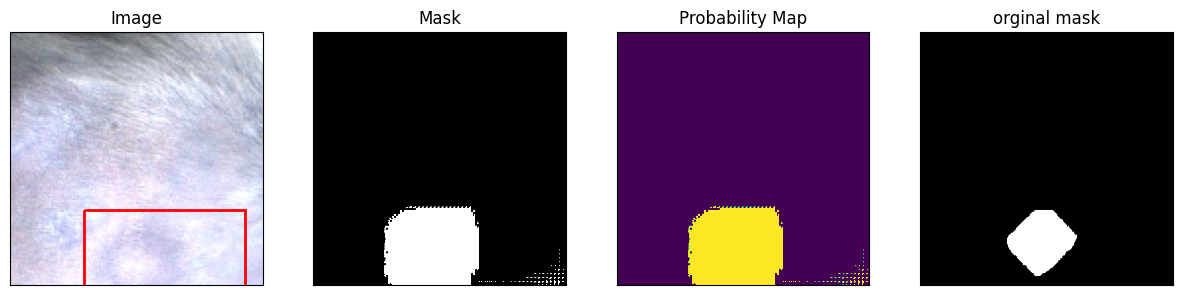

In [59]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# let's take a random training example
idx = random.randint(0, len(testing_raw))

# load image
test_image = testing_raw[idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = testing_masks[idx]

# test bounding box 
bbox = [0,0,256,256]

# test with pointer prompt 
pointer_prompt = [128,128]

prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

bbox = prompt  # Assuming prompt is the bounding box coordinates
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask
axes[3].imshow(training_masks[idx], cmap = "gray")
axes[3].set_title("orginal mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## Now test with a pointer

In [124]:
# random image 
rand = random.randint(0, len(testing_raw))
image = testing_raw[rand]
mask = testing_masks[rand] 

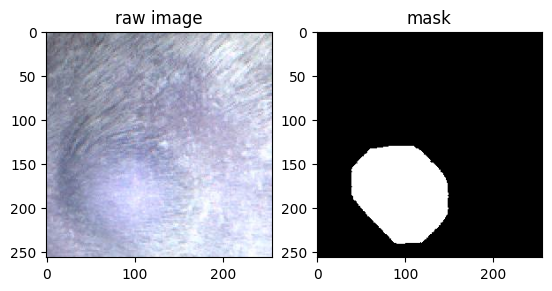

In [125]:
# now display that image

fig, ax = plt.subplots(1,2) 

ax[0].imshow(image)
ax[0].set_title('raw image') 

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('mask') 

plt.show()

Text(0.5, 1.0, 'Orignal Mask')

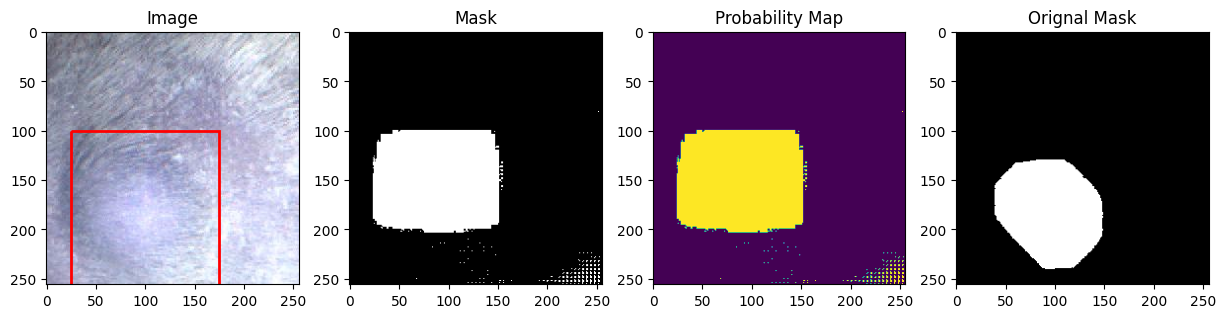

In [128]:
# get the input 
point = [25, 100, 150, 200]

# prepare image
inputs = processor(image, input_boxes=[[point]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1,4, figsize=(15, 5)) 

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

bbox = point  # Assuming prompt is the bounding box coordinates
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask 
axes[3].imshow(mask, cmap="gray") 
axes[3].set_title("Orignal Mask")




## Now test with array of points

Text(0.5, 1.0, 'Probability Map')

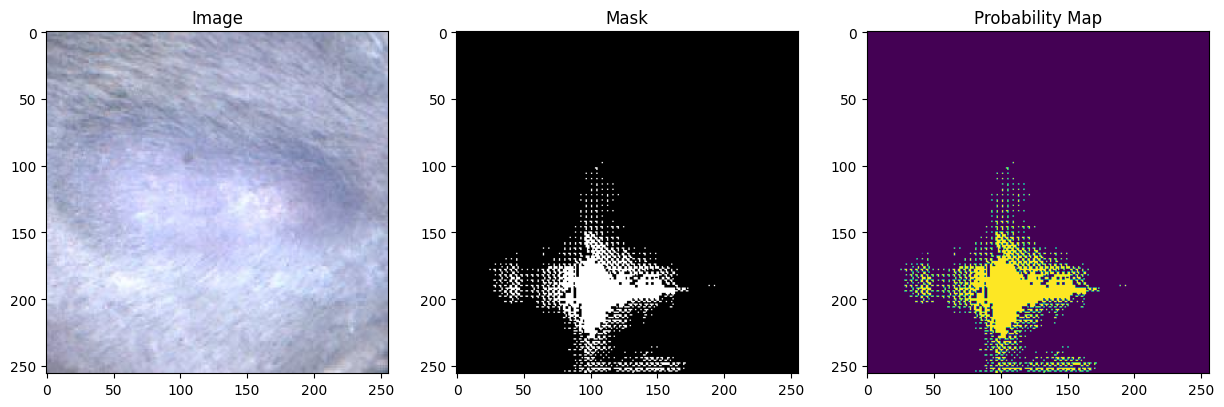

In [82]:
# random image 
rand = random.randint(0, len(testing_raw))
image = testing_raw[rand]
mask = testing_masks[rand] 

# Generate points for a 256x256 grid
x = np.arange(0, 256)
y = np.arange(0, 256)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T

input = points 

# prepare image
inputs = processor(image, input_points=[[point]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1,3, figsize=(15, 5)) 

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

